In [1]:
import geopandas as geopd
import pandas as pd
from shapely.geometry import box

import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

import numpy as np

try:# yoga
    from whitebox.WBT.whitebox_tools import WhiteboxTools
except:# fossa
    from whitebox.whitebox_tools import WhiteboxTools

import os

from time import sleep

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
#gauge_path = "/home/iielse/Documents/DIWA/data/omat digitoinnit/CAMELS-FI flow gauges.gpkg"

# For bea
gauge_path = "/home/iielse/Documents/DIWA/bea/aurajoki_nutrients.gpkg"
gauges = geopd.read_file(gauge_path, layer="locations")

catchments_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_basins.gpkg"
#gauges = geopd.read_file(gauge_path, layer="v1")
catchments = geopd.read_file(catchments_path, layer='v1')


catchments = catchments.reset_index(names=['catch_id'])


gauges = geopd.sjoin(gauges[['Paikka_Id', 'geometry']], catchments[['catch_id', 'geometry']], how='left')

gauges = gauges.drop('index_right', axis=1)

In [3]:
assert gauges['catch_id'].isna().sum() == 0, "Some points fall outside the catchments"

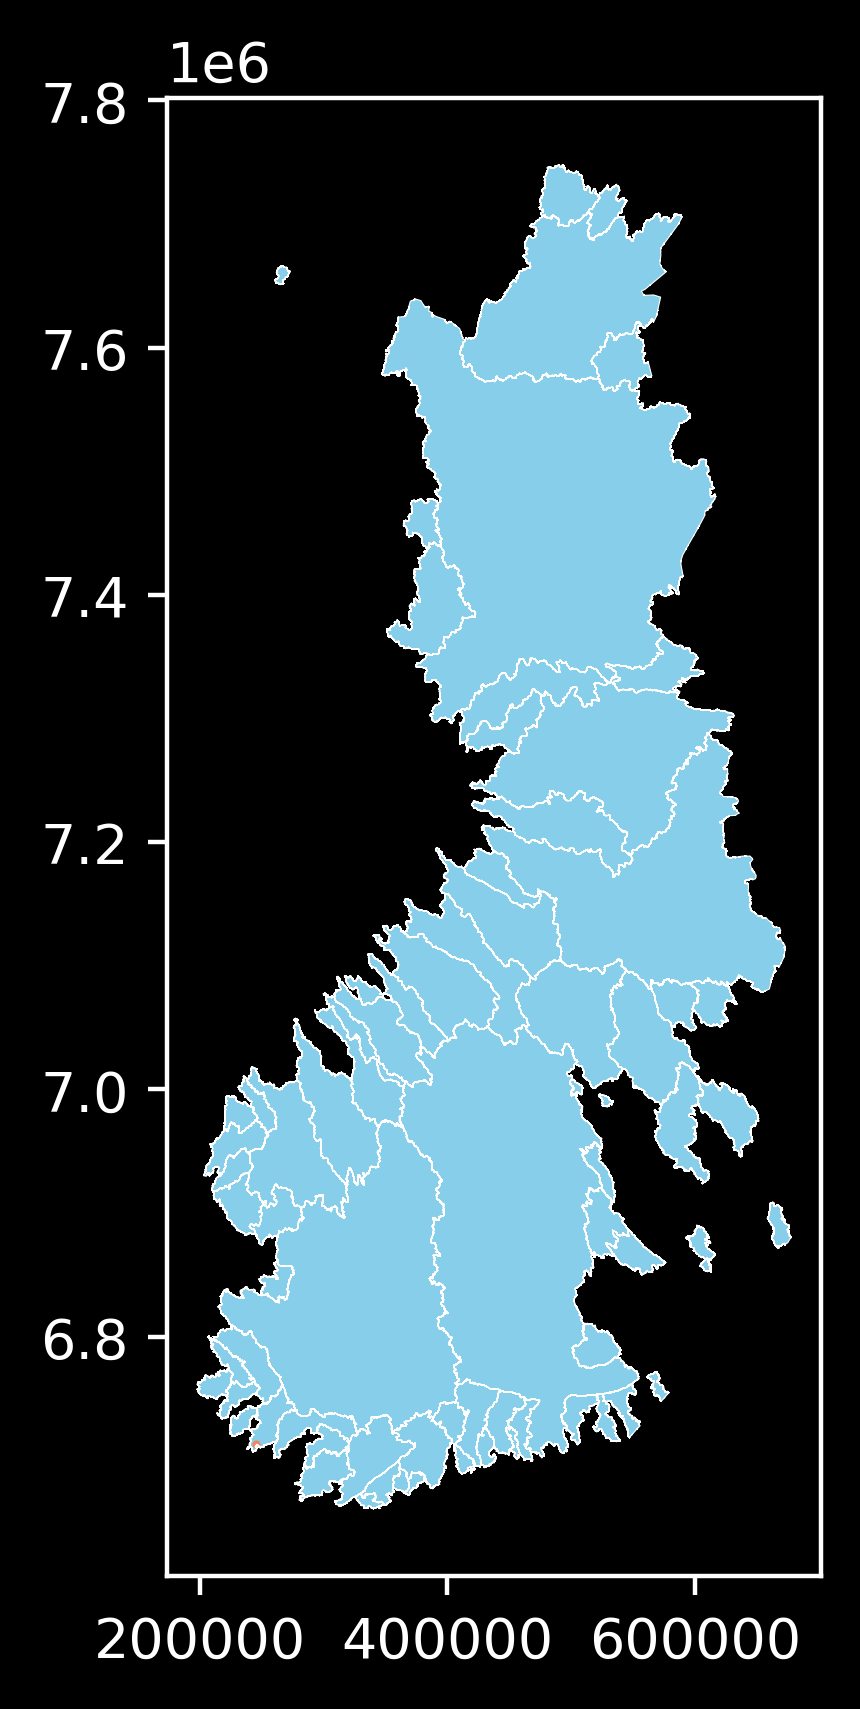

In [4]:

ax = catchments.boundary.plot(linewidth=0.2)
ax = catchments.plot(ax=ax, color='skyblue')
ax = gauges.plot(ax=ax, markersize=0.2, color='coral')

In [5]:
# special case for some fixes
catchments = catchments[(catchments['catch_id'] == 39)]
catchments

,catch_id,taso2_osai,taso2_osat,taso2_id,paavesisto,nimi,osavalu_pa,ylavalu_pa,taso1_osat,valtio,muutospvm,Shape_STAr,Shape_STLe,area_m2,geometry
39,39,1128.0,FI1-28,128.0,28.0,Aurajoen vesistöalue,869.03,869.03,FI1,FI,2023-05-09,869034000.0,391980.0,869034000.0,"MULTIPOLYGON (((245060 6710750, 245050 6710750..."


In [6]:
gauges

,Paikka_Id,geometry,catch_id
0,54,POINT (245157.645 6713430.735),39


In [7]:
wbt = WhiteboxTools()
wbt.set_verbose_mode(True)

root = "/media/iielse/T9/gisT7/korkeusmalli_10_m"
#root = '/home/iiro/980/GIS980/korkeusmalli_10_m'

stream_dir = os.path.join(root, "stream_thresholding")
d8_dir = os.path.join(root, "d8_pointer")

tmp_dir = "/tmp/stream_processing"
if not os.path.isdir(tmp_dir):
        os.mkdir(tmp_dir)
    
point_tmp_path = os.path.join(tmp_dir, "pour_points.shp")
snapped_tmp_path = os.path.join(tmp_dir, "snapped_points.shp")

with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
    for i, catchment in pbar:
        locations = gauges.loc[gauges['catch_id'] == i]
        counter = 0

        stream_path = os.path.join(stream_dir, f"stream_thresholding_{i}.tif")
        d8_path = os.path.join(d8_dir, f"d8_pointer_{i}.tif")

        
        """
        Every pour point needs to be processed separately so that whiteboxtools will handle it correctly
        and generate the entire watershed for the pour point.
        """
        for j, location in locations.iterrows():
            counter += 1
            pbar.set_description(f"processing pour point {counter}/{len(locations)} of catchment {i}")

             # Converting from series to GeoDataFrame
            location = geopd.GeoDataFrame(
                    dict(zip(list(location.index), list(location.values))),
                    crs=locations.crs, geometry='geometry', index=[0])

            # Each watershed is put to directory watershed/pour_point_id/full
            # The watershed will later be subdivided  and that will be put to watershed/pour_point_id/subshed
            dst_dir = os.path.join(root, "watershed", location.at[0, 'Paikka_Id'], "full")
            
            if not os.path.isdir(dst_dir):
                os.makedirs(dst_dir)
            
            watershed_path = os.path.join(dst_dir, f"watershed_{location.at[0, 'Paikka_Id']}.tif")

            # skipping already calculated ones
            #if os.path.exists(watershed_path):
                #continue
            
            location.to_file(point_tmp_path)
            # snapping to flow path
            wbt.jenson_snap_pour_points(point_tmp_path, stream_path, snapped_tmp_path, 500)

            # Watershed calculation
            wbt.watershed(d8_path, snapped_tmp_path, watershed_path)
            

  0%|          | 0/1 [00:00<?, ?it/s]

./whitebox_tools --run="JensonSnapPourPoints" --pour_pts='/tmp/stream_processing/pour_points.shp' --streams='/media/iielse/T9/gisT7/korkeusmalli_10_m/stream_thresholding/stream_thresholding_39.tif' --output='/tmp/stream_processing/snapped_points.shp' --snap_dist='500' -v --compress_rasters=False

***********************************
* Welcome to JensonSnapPourPoints *
* Powered by WhiteboxTools        *
* www.whiteboxgeo.com             *
***********************************
Reading data...
Progress: 0%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.0s
./whitebox_tools --run="Watershed" --d8_pntr='/media/iielse/T9/gisT7/korkeusmalli_10_m/d8_pointer/d8_pointer_39.tif' --pour_pts='/tmp/stream_processing/snapped_points.shp' --output='/media/iielse/T9/gisT7/korkeusmalli_10_m/watershed/54/full/watershed_54.tif' -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
*******************

In [25]:
catchments

,catch_id,taso2_osai,taso2_osat,taso2_id,paavesisto,nimi,osavalu_pa,ylavalu_pa,taso1_osat,valtio,muutospvm,Shape_STAr,Shape_STLe,area_m2,geometry
0,39,1128.0,FI1-28,128.0,28.0,Aurajoen vesistöalue,869.03,869.03,FI1,FI,2023-05-09,869034000.0,391980.0,869034000.0,"MULTIPOLYGON (((245060 6710750, 245050 6710750..."


In [9]:
location

,Paikka_Id,geometry,catch_id
0,54,POINT (245157.645 6713430.735),39
